# Preprocessing

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Importing Dataset

Importing the KDDCup 10 percent dataset and adding column names to it

In [2]:
columns = np.append(pd.read_csv('data/col_names.csv').columns.values, 'type')
df = pd.read_csv("data/kddcup10p.csv", names=columns)

In [3]:
print(df.columns)
print(df.shape)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'type'],
      dtype='object')
(494021, 42)


### Checking for Correlated Data

In [4]:
df = df.dropna(axis=1)
df = df[[col for col in df if df[col].nunique() > 1]]
corrdf = df.select_dtypes(include=[np.number])

In [5]:
print(corrdf)

        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0        181       5450     0               0       0    0   
1              0        239        486     0               0       0    0   
2              0        235       1337     0               0       0    0   
3              0        219       1337     0               0       0    0   
4              0        217       2032     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
494016         0        310       1881     0               0       0    0   
494017         0        282       2286     0               0       0    0   
494018         0        203       1200     0               0       0    0   
494019         0        291       1200     0               0       0    0   
494020         0        219       1234     0               0       0    0   

        num_failed_logins  logged_in  num_compromised  ...  dst_host_count 

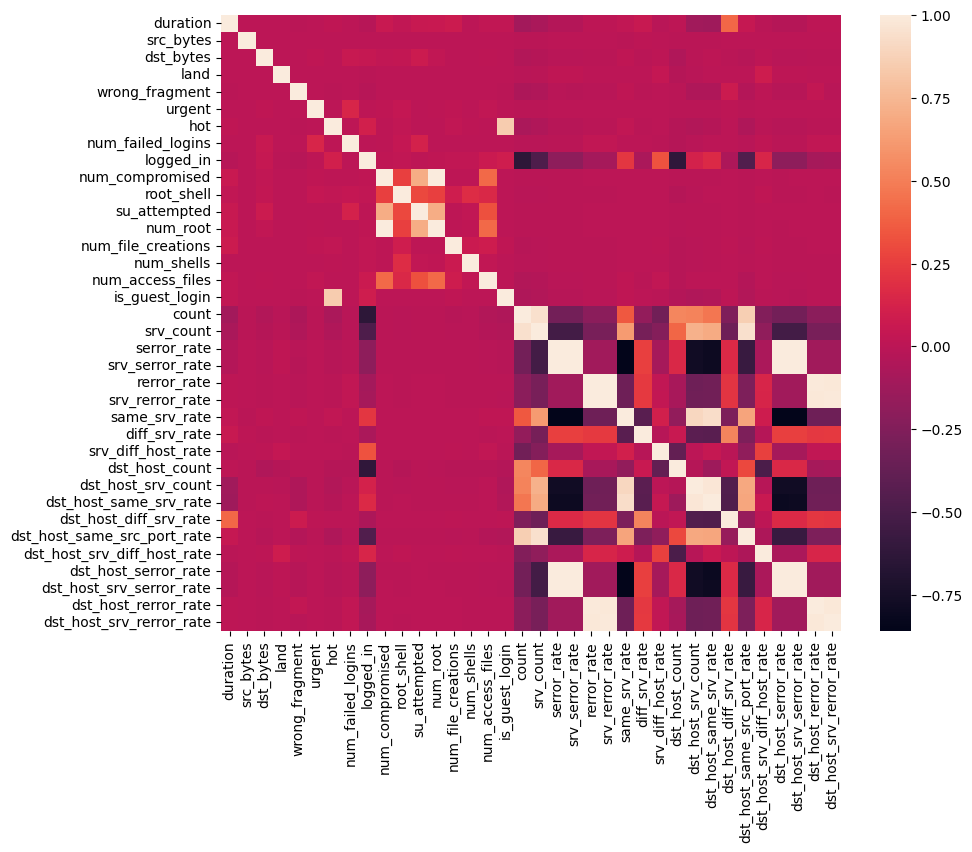

In [6]:
corr = corrdf.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr)
plt.show()

In [7]:
correlated_vars = []

for i, col1 in enumerate(corrdf.columns):
    for j, col2 in enumerate(corrdf.columns[i + 1:]):
        if col2 not in correlated_vars:
            if corrdf[col1].corr(corrdf[col2]) > 0.95:
                # print(f"{col1} and {col2} are highly positively correlated")
                correlated_vars.append(col2)
            elif corrdf[col1].corr(corrdf[col2]) < -0.95:
                # print(f"{col1} and {col2} are highly negatively correlated")
                correlated_vars.append(col2)
            

In [8]:
print(correlated_vars)

['num_root', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'dst_host_same_srv_rate']


In [9]:
for col in correlated_vars:
    df.drop(col, axis=1, inplace=True)

In [10]:
print(df.columns)
print(df.shape)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files',
       'is_guest_login', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'type'],
      dtype='object')
(494021, 32)


### Separating Dataset Into Dependent and Independent Features and Encoding Categorical Data

In [11]:
X = df.iloc[:, :-1].values
Y = df.iloc[:,-1].values

In [12]:
print(X)

[[0 'tcp' 'http' ... 0.0 0.11 0.0]
 [0 'tcp' 'http' ... 0.0 0.05 0.0]
 [0 'tcp' 'http' ... 0.0 0.03 0.0]
 ...
 [0 'tcp' 'http' ... 0.0 0.06 0.05]
 [0 'tcp' 'http' ... 0.0 0.04 0.05]
 [0 'tcp' 'http' ... 0.0 0.17 0.05]]


In [13]:
print(Y)

['normal.' 'normal.' 'normal.' ... 'normal.' 'normal.' 'normal.']


Converting the categorical columns of the independent features using ColumnTransformer and OneHotEncoder with drop="first" to prevent multicollinearity

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# columns 1, 2, and 3 correspond to protocol_type, service, and flag respectively
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop="first", sparse_output=False), [1, 2, 3])], remainder="passthrough")

In [15]:
X = ct.fit_transform(X)

In [16]:
print(X)

[[1.0 0.0 0.0 ... 0.0 0.11 0.0]
 [1.0 0.0 0.0 ... 0.0 0.05 0.0]
 [1.0 0.0 0.0 ... 0.0 0.03 0.0]
 ...
 [1.0 0.0 0.0 ... 0.0 0.06 0.05]
 [1.0 0.0 0.0 ... 0.0 0.04 0.05]
 [1.0 0.0 0.0 ... 0.0 0.17 0.05]]


Using a LabelEncoder to convert the output categories to labels

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [18]:
Y = le.fit_transform(Y)

In [19]:
print(Y)

[11 11 11 ... 11 11 11]


### Creating the Training and Test Sets

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=11)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(370515, 105)
(123506, 105)
(370515,)
(123506,)


### Feature Scaling

In [22]:
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()


In [23]:
X_train = ssc.fit_transform(X_train)
X_test = ssc.transform(X_test)

# Creating the Model

### SGDClassifier With loss="log_loss"

Creating the Classifier

In [24]:
from models.SISA import SISA
# prediction time increases with shard number, since more shards means more models that have to make a prediction for the aggregate
sisa_classifier = SISA(shards=5, slices=5)

Training the Classifier

In [25]:
sisa_classifier.fit(X_train, Y_train)

Evaluating the Classifier

In [26]:
from sklearn.metrics import accuracy_score

print("Accuracy Score: ", accuracy_score(Y_test, sisa_classifier.predict(X_test)))
# print("Training Set Score: ", sgd_log_classifier.score(X_train, Y_train))
# sgd_log_classifier_score = sgd_log_classifier.score(X_test, Y_test)
# print("Testing Set Score: ", sgd_log_classifier_score)

Accuracy Score:  0.9972228069891341
